In [3]:
import dgl
import dgl.function as fn
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph
import pandas as pd
import torch
import sklearn.metrics
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("pokec-df-processed2.csv", index_col=0)

In [4]:
edges = pd.read_csv("pokec-edges-processed2.csv", index_col=0)

In [5]:
# фичи и возраст
node_features = df.loc[:, df.columns != 'AGE'].values
node_labels = df.loc[:, df.columns == 'AGE'].values.flatten()
node_features = torch.FloatTensor(node_features)
node_labels = torch.LongTensor(node_labels)

In [6]:
num_features = node_features.shape[1]
num_classes = (node_labels.max() + 1).item()

In [7]:
graph = dgl.graph((edges.values[:, 0], edges.values[:, 1]))

In [8]:
ind = df.index.values
with open('train2.txt', 'r') as file:
    train_nids = [int(x) for x in file]
with open('test2.txt', 'r') as file:
    test_nids = [int(x) for x in file]

In [24]:
gcn_msg = fn.copy_u(u="h", out="m")
gcn_reduce = fn.sum(msg="m", out="h")

In [10]:
class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)

    def forward(self, g, feature):
        with g.local_scope():
            g.ndata["h"] = feature
            g.update_all(gcn_msg, gcn_reduce)
            h = g.ndata["h"]
            return self.linear(h)

In [25]:
class Net(nn.Module):
    def __init__(self, in_size, hid_size, out_size):
        super(Net, self).__init__()
        self.layer1 = GCNLayer(in_size, hid_size)
        self.layer2 = GCNLayer(hid_size, out_size)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, g, features):
        x = F.relu(self.layer1(g, features))
        x = self.dropout(x)
        x = self.layer2(g, x)
        return x

In [13]:
def predict(g, features, labels, mask, model):
    model.eval()
    with torch.no_grad():
        logits = model(g, features)
        logits = logits[mask]
        labels = labels[mask]
        _, indices = torch.max(logits, dim=1)
        return indices

In [30]:
best_model_path = 'GCN_model.pt'

Epoch 00000 | Loss 31252.4355 | mae 38.1905 | Time(s) 2.9623
Epoch 00001 | Loss 26519.2754 | mae 38.7325 | Time(s) 2.5661
Epoch 00002 | Loss 22206.9180 | mae 39.6604 | Time(s) 2.4394
Epoch 00003 | Loss 18231.3906 | mae 37.2262 | Time(s) 2.4927
Epoch 00004 | Loss 15035.2207 | mae 16.6954 | Time(s) 2.4614
Epoch 00005 | Loss 12846.8193 | mae 12.7884 | Time(s) 2.4426
Epoch 00006 | Loss 11417.4023 | mae 8.8483 | Time(s) 2.7084
Epoch 00007 | Loss 10200.7871 | mae 8.1893 | Time(s) 2.5184
Epoch 00008 | Loss 8972.3193 | mae 9.7725 | Time(s) 2.3188
Epoch 00009 | Loss 7743.6021 | mae 8.2032 | Time(s) 2.4762
Epoch 00010 | Loss 6528.7476 | mae 9.0822 | Time(s) 2.4726
Epoch 00011 | Loss 5493.1616 | mae 10.3627 | Time(s) 2.7871
Epoch 00012 | Loss 4682.0679 | mae 9.2072 | Time(s) 2.2487
Epoch 00013 | Loss 4129.1362 | mae 10.1282 | Time(s) 2.3365
Epoch 00014 | Loss 3576.8989 | mae 9.5219 | Time(s) 2.2840
Epoch 00015 | Loss 3085.9968 | mae 9.0877 | Time(s) 2.3614
Epoch 00016 | Loss 2734.6907 | mae 10.74

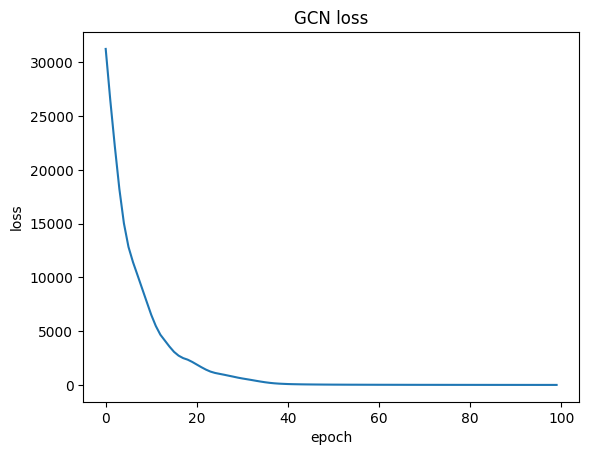

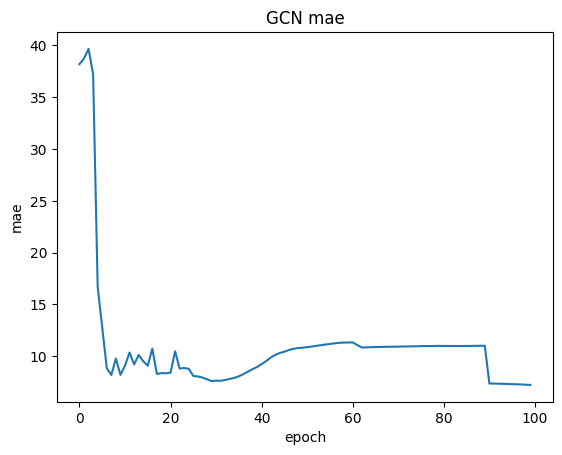

In [38]:
import time

import numpy as np
model = Net(num_features, 9, num_classes)
g = graph
features = node_features
labels = node_labels
train_mask = torch.BoolTensor(np.isin(ind, train_nids))
test_mask = torch.BoolTensor(np.isin(ind, test_nids))
# Add edges between each node and itself to preserve old node representations
g.add_edges(g.nodes(), g.nodes())
optimizer = th.optim.Adam(model.parameters(), lr=1e-2)
train_loss = []
train_mae = []
num_epochs = 100
best_mae = 10**10
for epoch in range(num_epochs):
    t0 = time.time()
    model.train()
    logits = model(g, features)
    logp = F.log_softmax(logits, 1)
    loss = F.nll_loss(logp[train_mask], labels[train_mask])
    train_loss.append(loss.item())
    train_mae.append(sklearn.metrics.mean_absolute_error(predict(g, features, labels, train_mask, model).numpy(), labels[train_mask].numpy()))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(
        "Epoch {:05d} | Loss {:.4f} | mae {:.4f} | Time(s) {:.4f}".format(
            epoch, loss.item(), train_mae[-1], time.time() - t0
        )
    )
    if best_mae > train_mae[-1]:
        best_mae = train_mae[-1]
        torch.save(model.state_dict(), best_model_path)
# plot loss
plt.plot(train_loss)
plt.title('GCN loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()
# plot accuracy
plt.plot(train_mae)
plt.title('GCN mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.show()

In [40]:
model.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

In [41]:
test_predictions = predict(g, features, labels, test_mask, model)
test_labels = node_labels[test_nids]
test_mae = sklearn.metrics.mean_absolute_error(test_predictions.numpy(), test_labels.numpy())
print('Test MAE:', test_mae)

Test MAE: 7.242944612569498
